In [2]:
from IPython.display import IFrame
IFrame(src="https://www.youtube.com/embed/SFdJ_1qnRDY", width=1920/2, height=1080/2)

In [50]:
from math import pi
from qiskit import qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector
from qiskit.circuit.library import QFT
%matplotlib inline

In [51]:
def make_qRAM(inputs):
    
    qc = QuantumCircuit(14)
    
    for indx in range(4):
        
        binary_indx = bin(4 + indx)[-2:]
        
        if binary_indx[0] == '0':
            qc.x(0)
        if binary_indx[1] == '0':
            qc.x(1)
            
        for j, value in enumerate(inputs[indx]):
            
            binary_value = bin(4 + value)[-2:]
            
            if binary_value[0] == '1':
                qc.ccx(0,1, 2 + 2 * j)
                
            if binary_value[1] == '1':
                qc.ccx(0,1, 2 + 2 * j + 1)
        
        if binary_indx[0] == '0':
            qc.x(0)
        if binary_indx[1] == '0':
            qc.x(1)
            
    gate = qc.to_gate()
    gate.name = 'qRAM'
    return gate

In [52]:
def add_qubit(qc, q, sign = 1):
      
    if q > 7:
        sign = -sign
        
    for indx, qb in enumerate(range(14,18)):
        qc.cp(sign * pi / (2**(3 - indx)), q, qb)

In [53]:
qft_norm = QFT(num_qubits=4, approximation_degree=0, do_swaps=False, inverse=False, insert_barriers=False, name='qft_gate')
qft_norm_gate = qft_norm.to_gate()

In [54]:
qft_inv = QFT(num_qubits=4, approximation_degree=0, do_swaps=False, inverse=True, insert_barriers=False, name='qft_inv_gate')
qft_inv_gate = qft_inv.to_gate()

In [55]:
def adder(qc, sign = 1):
    qc.append(qft_norm_gate, range(14,18))

    for q in range(2,14):
    
        add_qubit(qc, q, sign)
    
        if q % 2 == 0:
            add_qubit(qc, q, sign)
        qc.barrier()
    
    qc.append(qft_inv_gate, range(14,18))

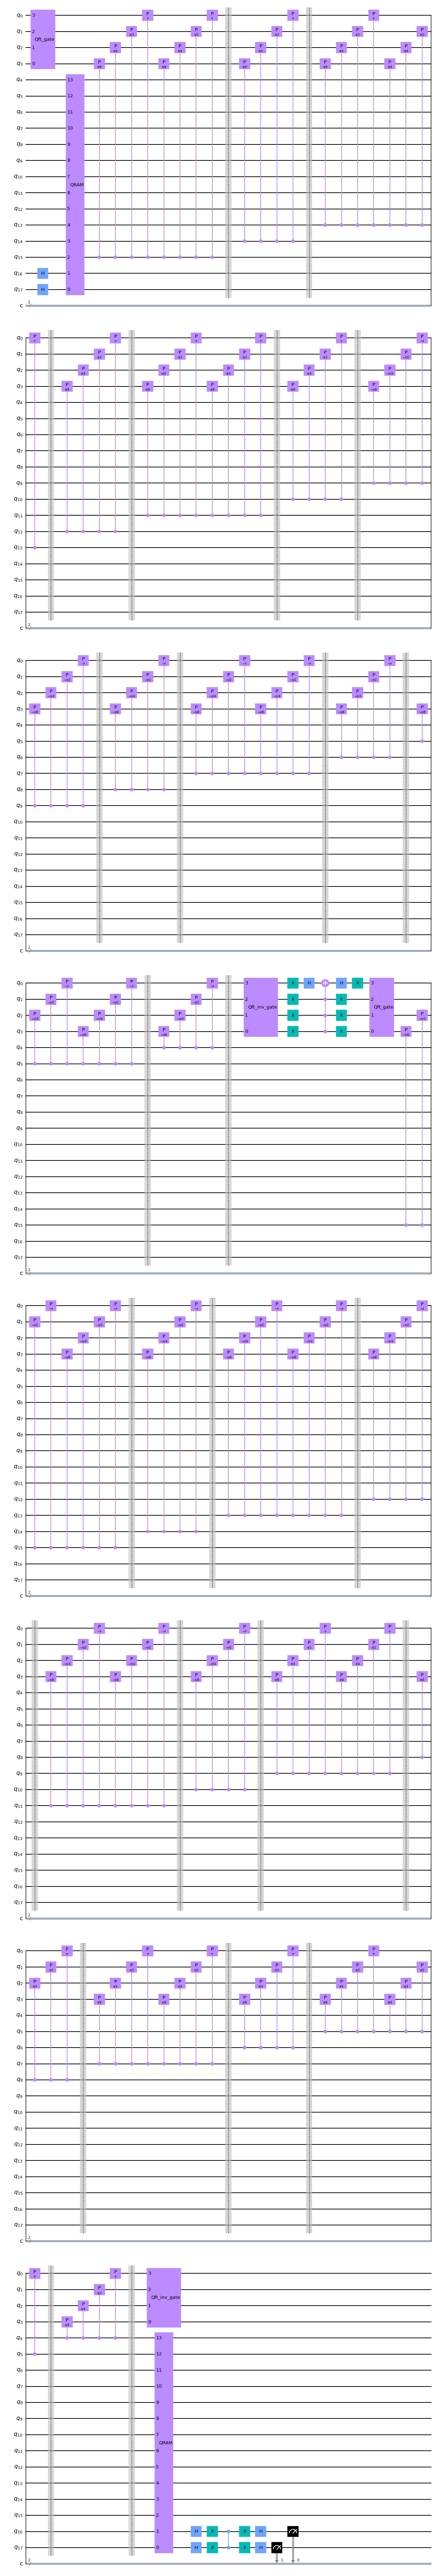

In [56]:
inputs = [[2,2,1,0,0,3], [1,3,2,3,3,1], [2,0,0,0,0,1], [1,1,2,1,3,0]]

qc = QuantumCircuit(18,2)
qc.h(range(2))
qc.append(make_qRAM(inputs), range(14))


adder(qc)

# oracle

qc.x(range(14,18))
qc.h(17)
qc.mct([14,15,16],17)
qc.h(17)
qc.x(range(14,18))



adder(qc, -1)
qc.append(make_qRAM(inputs), range(14))

# grover

qc.h(range(2))
qc.x(range(2))
qc.cz(0,1)
qc.x(range(2))
qc.h(range(2))

qc.measure(range(2), range(2))
qc = qc.reverse_bits()

qc.draw(output='mpl')

In [57]:
backend = qiskit.Aer.get_backend("qasm_simulator")
job = qiskit.execute(qc, backend, shots = 1000)
counts = job.result().get_counts()

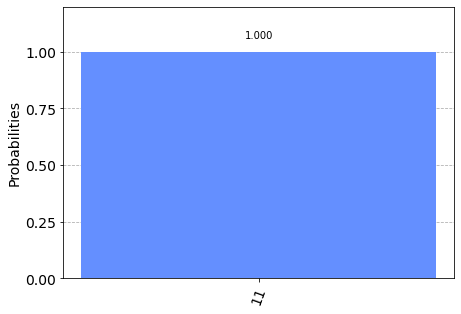

In [58]:
plot_histogram(counts)